In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

# Семинар 8. Диффузионные сети на практике

В этом семинаре разберем (предоложительно) Stable diffusion! библиотеку diffusers, DiT и узнаем про трекинг в ClearML?

## SD from scratch

Построим сначала SD с нуля. У нас уже все для этого есть - мы знаем процесс диффузии, только вместо того чтобы восстанавливать самое изображение из шума. Эта часть блокнота ознакомительная и нацелена на то чтобы показать как работают составные части сд

### VQ-VAE


В обучении LDM VQ-VAE играет роль модели снижения размерности. Процесс диффузии будет применяться к сжатому изображению.



In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=10, embedding_dim=128):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        flat_input = inputs.view(-1, self._embedding_dim)

        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        quantized = inputs + (quantized - inputs).detach()
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        return quantized

In [ ]:
class Encoder(nn.Module):
    def __init__(self, ch=3, hidden_dim=128):
        super().__init__()

        self.enc = nn.Sequential(
            # b c 256 256
            nn.Conv2d(ch, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            # b c 128 128
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            # b c 64 64
            nn.Conv2d(hidden_dim*2, ch, kernel_size=1, stride=1, padding=0),
            # b c 64 64
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return self.enc(x)


class Decoder(nn.Module):
    def __init__(self, ch=3, hidden_dim=128):
        super().__init__()
        self.dec = nn.Sequential(
            # b c 64 64
            nn.Conv2d(ch, hidden_dim*2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            # b c 64 64
            nn.ConvTranspose2d(hidden_dim*2, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            # b c 128 128
            nn.ConvTranspose2d(hidden_dim, hidden_dim // 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            # b c 128 128
            nn.ConvTranspose2d(hidden_dim // 2, ch, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.dec(x)

In [ ]:
inp = torch.randn(1, 3, 64, 64)

decoder = Decoder()
out = decoder(inp)
print(out.shape)

torch.Size([1, 3, 256, 256])


In [ ]:
class VQModel(nn.Module):
    def __init__(self, ch=3, n_embed=8192, emb_dim=3):
      super().__init__()

      self.enc = Encoder(ch)
      self.dec = Decoder(ch)

      self.quant = VectorQuantizer(n_embed, emb_dim)

      # свертки для конвертации размерностей выходов тензоров для квантизации и после нее
      self.quant_conv = nn.Conv2d(ch, emb_dim, 1)
      self.post_quant_conv = nn.Conv2d(emb_dim, ch, 1)

    def encode(self, x):
      out = self.enc(x)
      out = self.quant_conv(out)
      return self.quant(out)

    def decode(self, x):
      out = self.post_quant_conv(x)
      return self.dec(out)

    def decode_code(self, code):
      out = self.quant._embedding(code)
      return self.decode(out)

    def forward(self, x):
      out = self.encode(x)
      return self.decode(out)

### UNet

UNet, как и в прошлый раз, будет отвечать за выучивание шума на каждом шаге диффузии. Авторы предлагают модифицировать архитектуру так, чтобы добавлять в каждый блок внимания информацию из других модальностей. Модифицируем наше внимание до CrossAttention.

In [ ]:
class ScaledDotProductAttention(nn.Module):
    # если не будет context, тогда будет простой attention
    def __init__(
        self,
        embed_dim: int = 768,
        context_dim: int = None,
        qkv_dim: int = 64,
        dropout_rate: float = 0.1,
    ):
        super().__init__()

        if context_dim is None:
           context_dim = embed_dim

        self.scale = 1 / (qkv_dim ** 0.5)
        self.q_linear = nn.Linear(embed_dim, qkv_dim)
        self.k_linear = nn.Linear(context_dim, qkv_dim)
        self.v_linear = nn.Linear(context_dim, qkv_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, context=None):
        batch_size, tokens, _ = x.shape

        if context is None:
            context = x

        if context.dim() == 2:  # [batch_size, context_dim]
            context = context.unsqueeze(1).expand(-1, tokens, -1)  # [batch_size, tokens, context_dim]


        Q = self.q_linear(x)
        K = self.k_linear(context)
        V = self.v_linear(context)

        attention_scores = torch.matmul(Q, K.mT) * self.scale
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        return attention_weights @ V

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(
        self,
        n_heads: int = 12,
        embed_dim: int = 768,
        context_dim: int = None,
        qkv_dim: int = 64,
        dropout_rate: float = 0.1,
    ):
        super().__init__()

        self.attns = torch.nn.ModuleList([
            ScaledDotProductAttention(
                embed_dim=embed_dim,
                context_dim=context_dim,
                qkv_dim=qkv_dim,
                dropout_rate=dropout_rate
                )
            for _ in range(n_heads)
        ])

        self.projection = torch.nn.Linear(n_heads * qkv_dim, embed_dim)

    def forward(self, x, context):
        heads_output = [attn(x, context) for attn in self.attns]
        concatenated = torch.cat(heads_output, dim=-1)
        output = self.projection(concatenated)
        return output

In [ ]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        embed_dim: int = 768,
        mlp_hidden_size: int = 3072,
        dropout_rate: float = 0.1,
    ):
        super().__init__()

        # обычный многослойный перцептрон, но с ориентиром на статью
        # не забываем про GELU
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_size),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_hidden_size, embed_dim),
            nn.Dropout(dropout_rate),
        )

    def forward(self, tensor):
        return self.mlp(tensor)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(
        self,
        n_heads,
        embed_dim,
        context_dim,
        qkv_dim,
        attn_drop,
        mlp_hidden_size,
        mlp_drop,
    ):
        super().__init__()
        self.mha = MultiHeadAttention(
            n_heads=n_heads,
            embed_dim=embed_dim,
            context_dim=context_dim,
            qkv_dim=qkv_dim,
            dropout_rate=attn_drop,
        )

        self.ln = nn.LayerNorm(embed_dim)


        self.mlp = MLP(embed_dim, mlp_hidden_size, mlp_drop)

    def forward(self, x, context=None):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)

        attn = self.ln(self.mha(x, context)) + x
        output = self.mlp(attn) + attn
        output = output.transpose(1, 2).view(B, -1, H, W)
        return output


In [ ]:
# базовый блок Conv + Norm + Act + Conv + Norm
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False, num_groups=8):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=num_groups, num_channels=mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
        )

    def forward(self, x):
        if self.residual:
            return x + F.gelu(self.double_conv(x))
        else:
            return self.double_conv(x)

# блок снижения размерности карты признаков
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256, num_groups=8):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True, num_groups=num_groups),
            DoubleConv(in_channels, out_channels, num_groups=num_groups),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t).unsqueeze(-1).unsqueeze(-1)
        return x + emb

# блок повышения размерности карты признаков
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256, num_groups=8):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True, num_groups=num_groups),
            DoubleConv(in_channels, out_channels, in_channels // 2, num_groups=num_groups),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = F.interpolate(x, size=skip_x.shape[-2:], mode="bilinear", align_corners=True)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t).unsqueeze(-1).unsqueeze(-1)
        return x + emb

In [ ]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, context_dim=256, device="cpu"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim

        self.inc = DoubleConv(c_in, 64)

        self.down1 = Down(64, 128)
        self.ca1 = TransformerBlock(
            n_heads=4, embed_dim=128, context_dim=context_dim, qkv_dim=32,
            attn_drop=0.1, mlp_hidden_size=512, mlp_drop=0.1
        )
        self.down2 = Down(128, 256)
        self.ca2 = TransformerBlock(
            n_heads=8, embed_dim=256, context_dim=context_dim, qkv_dim=32,
            attn_drop=0.1, mlp_hidden_size=1024, mlp_drop=0.1
        )

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.ca3 = TransformerBlock(
            n_heads=4, embed_dim=128, context_dim=context_dim, qkv_dim=32,
            attn_drop=0.1, mlp_hidden_size=512, mlp_drop=0.1
        )
        self.up2 = Up(256, 64)
        self.ca4 = TransformerBlock(
            n_heads=2, embed_dim=64, context_dim=context_dim, qkv_dim=32,
            attn_drop=0.1, mlp_hidden_size=256, mlp_drop=0.1
        )
        self.up3 = Up(128, 64)

        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        assert t.dim() == 2, f"Expected shape (batch_size, 1), got {t.shape}"
        device = t.device
        inv_freq = 1.0 / (
            10000 ** (torch.arange(0, channels, 2, device=device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, t_theta):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.ca1(x2, t_theta)
        x3 = self.down2(x2, t)
        x3 = self.ca2(x3, t_theta)

        xb = self.bot1(x3)
        xb = self.bot2(xb)
        xb = self.bot3(xb)

        x = self.up1(xb, x3, t)
        x = self.ca3(x, t_theta)
        x = self.up2(x, x2, t)
        x = self.ca4(x, t_theta)
        x = self.up3(x, x1, t)

        output = self.outc(x)
        return output

In [ ]:
model = UNet().cuda()

B = 1
x = torch.randn(B, 3, 64, 64).cuda()   # image
t = torch.randn(B).cuda()           # time scalar
t_theta = torch.randn(B, 256).cuda()         # context embedding

out = model(x, t, t_theta)
print("Output shape =", out.shape)  # should be [B, c_out, 64, 64]


Output shape = torch.Size([1, 3, 64, 64])


### Кодировщик модальностей

Кодировщиком молальности может выступать что угодно, в зависимости от модальности. Например, это может быть берт как кодировщик текста или клип как кодировщик изображений или любой другой кодировщик, который вы выберете.

In [ ]:
from transformers import BertTokenizerFast, BertModel

class BERTTokenizer(nn.Module):
    """Uses a pretrained BERT tokenizer and model for embeddings."""
    def __init__(self, device="cpu", max_length=77):
        super().__init__()
        # Load BERT tokenizer and model
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
        self.bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

        self.device = device
        self.max_length = max_length
        self.context_dim = self.bert_model.config.hidden_size  # 768 for bert-base-uncased

    def forward(self, text):
        """
        Tokenizes the text and computes BERT embeddings.
        :param text: List of strings
        :return: Embeddings [B, max_length, context_dim]
        """
        # Tokenize text input
        batch_encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        ).to(self.device)

        # Get embeddings from BERT
        with torch.no_grad():
            outputs = self.bert_model(**batch_encoding)

        # Use the last hidden state as embeddings
        embeddings = outputs.last_hidden_state  # Shape: [B, max_length, context_dim]
        return embeddings

    def encode(self, text):
        """
        Compatibility function for downstream use. Returns BERT embeddings.
        """
        return self(text)

    def decode(self, tokens):
        """
        Decodes tokens back to text.
        """
        return self.tokenizer.batch_decode(tokens, skip_special_tokens=True)


In [ ]:
# Initialize tokenizer and model
bert_tokenizer = BERTTokenizer()
unet_model = UNet(context_dim=bert_tokenizer.context_dim)

# Example inputs
text_input = ["This is an example sentence for generating embeddings."]
image_input = torch.randn(1, 3, 64, 64)
time_input = torch.randn(1)

# Get embeddings from BERT
context_embeddings = bert_tokenizer(text_input)  # [B, max_length, context_dim]

# Pass everything into U-Net
output = unet_model(image_input, time_input, context_embeddings)
print("Output shape:", output.shape)


Output shape: torch.Size([1, 3, 64, 64])


### Diffusion

In [ ]:
class Diffusion:
    def __init__(
            self,
            noise_steps=1000,   # количество шагов зашумления
            beta_start=1e-4,    # начальное значение параметра beta
            beta_end=0.02,      # конечное значение параметра beta
            img_size=256,       # размер изображения
            device="cpu",
            ):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        # создадим массив параметров beta
        self.beta = self.prepare_noise_schedule().to(device)
        # вычислим параметр alpha
        self.alpha = 1. - self.beta
        # посчитаем массив alpha_hat
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        # зашуим изображения
        # доп. размерности указыванием для согласования с размерностями х
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        # инициализируем шаги зашумления как случайный вектор
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, x, theta):
        model.eval()
        n = x.size(0)
        with torch.no_grad():
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, theta)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    # если i != 0, тогда epsilon будет случайным вектором
                    noise = torch.randn_like(x)
                else:
                    # если i = 0, то есть мы уже пришли к нужному изображению, тогда не будем к нему добавлять epsilon
                    noise = torch.zeros_like(x)

                # вычисляем наше изображение по формуле
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        return x

### Собираем все воедино

In [ ]:
class InferenceSD(nn.Module):
    def __init__(
        self,
        vqmodel,
        unet,
        modality_encoder,
        diffusion,
    ):
        super().__init__()
        self.vqmodel = vqmodel
        self.unet = unet
        self.modality_encoder = modality_encoder

        self.diffusion = diffusion

    def forward(self, x, t, theta):
        z = self.vqmodel.encode(x)

        theta = self.modality_encoder(theta)

        predicted_noise = self.unet(x, t, theta)

        x_hat = self.vqmodel.decode(predicted_noise)
        return predicted_noise, x_hat

    def predict(self, x, theta):
        theta = self.modality_encoder(theta)

        z_hat = self.diffusion.sample(
            self.unet,
            x,
            theta
        )

        x_hat = self.vqmodel.decode(z_hat)
        return x_hat

In [ ]:
diffusion = Diffusion()
vqmodel = VQModel()
bert_tokenizer = BERTTokenizer()
unet = UNet(context_dim=bert_tokenizer.context_dim)

sd = InferenceSD(
    vqmodel,
    unet,
    bert_tokenizer,
    diffusion,
)


text_input = ["This is an example sentence for generating embeddings."]
B = 1
z_input = torch.randn(B, 3, 64, 64)


output = sd.predict(z_input, text_input)
print("Output shape:", output.shape)


999it [05:06,  3.25it/s]


Output shape: torch.Size([1, 3, 256, 256])


# SD from diffusers

In [ ]:
import torch
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0").to("cuda")
generator = torch.Generator("cuda").manual_seed(0)

pipeline.enable_attention_slicing()  # Enable slicing for memory-efficient attention
pipeline.to(torch.float16)           # Use half-precision

height, width = 512, 512  # Reduce resolution


promt = "pepe the frog meme sad face but happy because holidays came and its cristmas"
image = pipeline(prompt=promt, generator=generator, height=height, width=width).images[0]

image.save("image.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

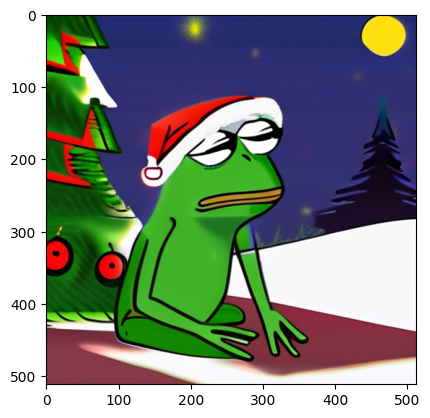

In [ ]:
import matplotlib.pyplot as plt
import cv2
plt.imshow(cv2.cvtColor(cv2.imread("image.png"), cv2.COLOR_BGR2RGB))